In [1]:
# Import all the tools we need
import numpy as np
import pandas as pd
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM, LinearSVC, SVC, SVR
from sklearn.metrics import accuracy_score

In [2]:
pursuit = pd.concat(map(pd.read_csv, ["D:\\ELSEC\\SortiModel\\data\\1.csv",
                                      "D:\\ELSEC\\SortiModel\\data\\2.csv",
                                      "D:\\ELSEC\\SortiModel\\data\\3.csv",
                                      "D:\\ELSEC\\SortiModel\\data\\4.csv"]), ignore_index=True)
clutter = pd.concat(map(pd.read_csv, ["D:\\ELSEC\\SortiModel\\data\\1.csv",
                                      "D:\\ELSEC\\SortiModel\\data\\2.csv",
                                      "D:\\ELSEC\\SortiModel\\data\\3.csv",
                                      "D:\\ELSEC\\SortiModel\\data\\4.csv"]), ignore_index=True)
print(f'Size of pursuit signals: {pursuit.shape}')
print(f'Size of clutter signals: {clutter.shape}')
pursuit = pursuit.drop(pursuit[pursuit.WeaponSystem == 'T5'].index)
clutter = clutter.drop(clutter[clutter.WeaponSystem != 'T5'].index)

pursuit.loc[pursuit.WeaponSystem == 'T5', 'Target'] = 0
pursuit.loc[pursuit.WeaponSystem != 'T5', 'Target'] = 1
pursuit.loc[pursuit['Target'] > 1.0, 'Target'] = 1
pursuit['Target'] = pursuit['Target'].fillna(0)

clutter.loc[clutter.WeaponSystem == 'T5', 'Target'] = 0
clutter.loc[clutter.WeaponSystem != 'T5', 'Target'] = 1
clutter.loc[clutter['Target'] > 1.0, 'Target'] = 1
clutter['Target'] = clutter['Target'].fillna(0)
pursuit['DF Type'] = pursuit['DF Type'].replace('BLI1', 1)
pursuit['DF Type'] = pursuit['DF Type'].replace('ADF', 2)
pursuit['DF Type'] = pursuit['DF Type'].replace('BLI2', 3)
pursuit['DF Type'] = pursuit['DF Type'].replace('ADF+BLI2', 4)
pursuit['DF Type'] = pursuit['DF Type'].replace('ADF+BLI1', 5)
pursuit['DF Type'].astype(int)

pursuit['Frequency Agility'] = pursuit['Frequency Agility'].replace('Fixed Frequency', 1)
pursuit['Frequency Agility'] = pursuit['Frequency Agility'].replace('LFM', 2)
pursuit['Frequency Agility'] = pursuit['Frequency Agility'].replace('LFM (Chirp-Up)', 3)
pursuit['Frequency Agility'] = pursuit['Frequency Agility'].replace('Frequency Agile', 4)
pursuit['Frequency Agility'] = pursuit['Frequency Agility'].replace("LFM (Chirp-Up) / Frequency Agile", 5)
pursuit['Frequency Agility'] = pursuit['Frequency Agility'].replace('LFM / Frequency Agile', 6)
pursuit['Frequency Agility'].astype(int)

pursuit['Pulse Agility'] = pursuit['Pulse Agility'].replace('Fixed PRI', 1)
pursuit['Pulse Agility'] = pursuit['Pulse Agility'].replace('Fixed Frequency', 2)
pursuit['Pulse Agility'] = pursuit['Pulse Agility'].replace('Stagger PRI', 3)
pursuit['Pulse Agility'] = pursuit['Pulse Agility'].replace('Dwell&Switch PRI', 4)
pursuit['Pulse Agility'] = pursuit['Pulse Agility'].replace('Frequency Agile', 5)
pursuit['Pulse Agility'] = pursuit['Pulse Agility'].replace('LFM', 5)
pursuit['Pulse Agility'].astype(int)

pursuit['TOLA'] = pursuit['TOLA'].str.replace(' ', '').str.split(':').apply(lambda x: int(x[0])*3600 + int(x[1])*60 + int(x[2]))
pursuit['TOLA'] = pursuit['TOLA'].astype(int)
pursuit['TOFA'] = pursuit['TOFA'].str.replace(' ', '').str.split(':').apply(lambda x: int(x[0])*3600 + int(x[1])*60 + int(x[2]))
pursuit['TOFA'] = pursuit['TOFA'].astype(int)

pursuit['TD'] = (pursuit['TOLA'] - pursuit['TOFA'])
pursuit['TD'].info()

pursuit_t1 =  pursuit.drop(pursuit[pursuit.WeaponSystem != 'T1'].index)
pursuit_t2 =  pursuit.drop(pursuit[pursuit.WeaponSystem != 'T2'].index)
pursuit_t3 =  pursuit.drop(pursuit[pursuit.WeaponSystem != 'T3'].index)
pursuit_t4 =  pursuit.drop(pursuit[pursuit.WeaponSystem != 'T4'].index)

pursuit = pursuit.select_dtypes(exclude='object')
pursuit = pursuit.drop(['Emitter Name'], axis=1)
print('Pursuit Dataset Revision done !')

pursuit_t1 = pursuit_t1.select_dtypes(exclude='object')
pursuit_t1 = pursuit_t1.drop(['Emitter Name'], axis=1)
pursuit_t2 = pursuit_t2.select_dtypes(exclude='object')
pursuit_t2 = pursuit_t2.drop(['Emitter Name'], axis=1)
pursuit_t3 = pursuit_t3.select_dtypes(exclude='object')
pursuit_t3 = pursuit_t3.drop(['Emitter Name'], axis=1)
pursuit_t4 = pursuit_t4.select_dtypes(exclude='object')
pursuit_t4 = pursuit_t4.drop(['Emitter Name'], axis=1)

clutter['DF Type'] = clutter['DF Type'].replace('BLI1', 1)
clutter['DF Type'] = clutter['DF Type'].replace('ADF', 2)
clutter['DF Type'] = clutter['DF Type'].replace('BLI2', 3)
clutter['DF Type'] = clutter['DF Type'].replace('ADF+BLI2', 4)
clutter['DF Type'] = clutter['DF Type'].replace('ADF+BLI1', 5)
clutter['DF Type'].astype(int)

clutter['Frequency Agility'] = clutter['Frequency Agility'].replace('Fixed Frequency', 1)
clutter['Frequency Agility'] = clutter['Frequency Agility'].replace('LFM', 2)
clutter['Frequency Agility'] = clutter['Frequency Agility'].replace('LFM (Chirp-Up)', 3)
clutter['Frequency Agility'] = clutter['Frequency Agility'].replace('Frequency Agile', 4)
clutter['Frequency Agility'] = clutter['Frequency Agility'].replace("LFM (Chirp-Up) / Frequency Agile", 5)
clutter['Frequency Agility'] = clutter['Frequency Agility'].replace('LFM / Frequency Agile', 6)
clutter['Frequency Agility'].astype(int)

clutter['Pulse Agility'] = clutter['Pulse Agility'].replace('Fixed PRI', 1)
clutter['Pulse Agility'] = clutter['Pulse Agility'].replace('Fixed Frequency', 2)
clutter['Pulse Agility'] = clutter['Pulse Agility'].replace('Stagger PRI', 3)
clutter['Pulse Agility'] = clutter['Pulse Agility'].replace('Dwell&Switch PRI', 4)
clutter['Pulse Agility'] = clutter['Pulse Agility'].replace('Frequency Agile', 5)
clutter['Pulse Agility'] = clutter['Pulse Agility'].replace('LFM', 5)
clutter['Pulse Agility'].astype(int)


clutter['TOLA'] = clutter['TOLA'].str.replace(' ', '').str.split(':').apply(lambda x: int(x[0])*3600 + int(x[1])*60 + int(x[2]))
clutter['TOLA'] = clutter['TOLA'].astype(int)
clutter['TOFA'] = clutter['TOFA'].str.replace(' ', '').str.split(':').apply(lambda x: int(x[0])*3600 + int(x[1])*60 + int(x[2]))
clutter['TOFA'] = clutter['TOFA'].astype(int)
clutter['TD'] = (clutter['TOLA'] - clutter['TOFA'])
clutter['TD'].info()

clutter = clutter.select_dtypes(exclude='object')
clutter = clutter.drop(['Emitter Name'], axis=1)
print('Clutter Dataset Revision done !')
print('Dataset processing done !') 

Size of pursuit signals: (19696, 97)
Size of clutter signals: (19696, 97)
<class 'pandas.core.series.Series'>
Index: 7856 entries, 1 to 19692
Series name: TD
Non-Null Count  Dtype
--------------  -----
7856 non-null   int32
dtypes: int32(1)
memory usage: 92.1 KB
Pursuit Dataset Revision done !
<class 'pandas.core.series.Series'>
Index: 11840 entries, 0 to 19695
Series name: TD
Non-Null Count  Dtype
--------------  -----
11840 non-null  int32
dtypes: int32(1)
memory usage: 138.8 KB
Clutter Dataset Revision done !
Dataset processing done !


C:\Users\RK Niranjan\AppData\Local\Temp\ipykernel_2688\2051842506.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pursuit['DF Type'] = pursuit['DF Type'].replace('ADF+BLI2', 4)
C:\Users\RK Niranjan\AppData\Local\Temp\ipykernel_2688\2051842506.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pursuit['Frequency Agility'] = pursuit['Frequency Agility'].replace("LFM (Chirp-Up) / Frequency Agile", 5)
C:\Users\RK Niranjan\AppData\Local\Temp\ipykernel_2688\2051842506.py:42: FutureWarning: Downcasting behavior in `replace` is dep

In [3]:
pursuit_test = pursuit.drop('Target', axis=1)
pursuit_res = pursuit['Target']
pursuit_t1_test = pursuit_t1.drop('Target', axis=1)
pursuit_t1_res = pursuit_t1['Target']
pursuit_t2_test = pursuit_t2.drop('Target', axis=1)
pursuit_t2_res = pursuit_t2['Target']
pursuit_t3_test = pursuit_t3.drop('Target', axis=1)
pursuit_t3_res = pursuit_t3['Target']
pursuit_t4_test = pursuit_t4.drop('Target', axis=1)
pursuit_t4_res = pursuit_t4['Target']

In [4]:
print(f'Size of Pursuit T1:{len(pursuit_t1)}')
print(f'Size of Pursuit T2:{len(pursuit_t2)}')
print(f'Size of Pursuit T3:{len(pursuit_t3)}')
print(f'Size of Pursuit T4:{len(pursuit_t4)}')

Size of Pursuit T1:1357
Size of Pursuit T2:1299
Size of Pursuit T3:4876
Size of Pursuit T4:324


In [5]:
pursuit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7856 entries, 1 to 19692
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Target                  7856 non-null   float64
 1   TOFA                    7856 non-null   int32  
 2   TOLA                    7856 non-null   int32  
 3   Hit Count               7856 non-null   int64  
 4   Frequency(MHz)          7856 non-null   float64
 5   Pulse Width(us)         7856 non-null   float64
 6   MaxAmplitude(dBm)       7856 non-null   float64
 7   AOA(Deg)                7856 non-null   float64
 8   DOA(Deg)                7856 non-null   float64
 9   DF Type                 7856 non-null   int64  
 10  Frequency Agility       7856 non-null   int64  
 11  Bandwidth(MHz)          7856 non-null   float64
 12  Pulse Agility           7856 non-null   int64  
 13  Pulse Count             7856 non-null   int64  
 14  Stagger/Jitter Level    7856 non-null   int6

In [6]:
train_size = int(len(pursuit_t3) * 0.8)
X_train = pursuit_t3_test[:train_size]
y_train = pursuit_t3_res[:train_size]

X_test = pursuit_t3_test[train_size:]
y_test = pursuit_t3_res[train_size:]

y_train_np = np.array(y_train)
num_ones_train = (y_train_np == 1).sum()
print(f'Total Number of Ones in Target Column of the training dataset: {num_ones_train}')
print(f'Total Number of Zeros in Target Column of the training dataset: {len(y_train) - num_ones_train}')
y_test_np = np.array(y_test)
num_ones_test = (y_test_np == 1).sum()
print(f'Total Number of Ones in Target Column of the test dataset: {num_ones_test}')
print(f'Total Number of Zeros in Target Column of the test dataset: {len(y_test) - num_ones_test}')
num_ones_test + num_ones_train, (len(y_test) - num_ones_test) + (len(y_train) - num_ones_train)

Total Number of Ones in Target Column of the training dataset: 3900
Total Number of Zeros in Target Column of the training dataset: 0
Total Number of Ones in Target Column of the test dataset: 976
Total Number of Zeros in Target Column of the test dataset: 0


(4876, 0)

In [7]:
# One-Class SVM
model_svm_01 = OneClassSVM(kernel='poly', gamma=0.5, nu=0.9)
#model_svm_01 = EllipticEnvelope(contamination=0.1, random_state=42)
#model_svm_01 =  LocalOutlierFactor(n_neighbors=20, contamination="auto", novelty=True)
#model_svm_01 = SVC(kernel='poly', degree=3, gamma='scale')
#model_svm_01 = SVR(kernel='poly', gamma='auto', C=1.0, epsilon=12)
#model_svm_01 = SGDClassifier(loss='log_loss', penalty='l2')
# Fit the model on the training data

model_svm_01.fit(X_train, y_train)

# Predict on the test data
y_pred_svm = model_svm_01.predict(X_test)

# Convert the predictions to 1 (anomaly) and 0 (normal)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Calculate and print the accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
#print(f'Prediction:', y_pred_svm)
print(f"Accuracy of One-Class SVM: {accuracy_svm}")

Accuracy of One-Class SVM: 0.6905737704918032


In [8]:
# Predict on the test data
y_pred_svm = model_svm_01.predict(pursuit_t1_test)

# Convert the predictions to 1 (anomaly) and 0 (normal)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Calculate and print the accuracy
accuracy_svm = accuracy_score(pursuit_t1_res, y_pred_svm)
#print(f'Prediction:', y_pred_svm)
print(f"Accuracy of One-Class SVM: {accuracy_svm}")

Accuracy of One-Class SVM: 0.14296241709653648


In [9]:
# Predict on the test data
y_pred_svm = model_svm_01.predict(pursuit_t2_test)

# Convert the predictions to 1 (anomaly) and 0 (normal)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Calculate and print the accuracy
accuracy_svm = accuracy_score(pursuit_t2_res, y_pred_svm)
#print(f'Prediction:', y_pred_svm)
print(f"Accuracy of One-Class SVM: {accuracy_svm}")

Accuracy of One-Class SVM: 1.0


In [10]:
# Predict on the test data
y_pred_svm = model_svm_01.predict(pursuit_t3_test)

# Convert the predictions to 1 (anomaly) and 0 (normal)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Calculate and print the accuracy
accuracy_svm = accuracy_score(pursuit_t3_res, y_pred_svm)
#print(f'Prediction:', y_pred_svm)
print(f"Accuracy of One-Class SVM: {accuracy_svm}")

Accuracy of One-Class SVM: 0.8574651353568499


In [11]:
# Predict on the test data
y_pred_svm = model_svm_01.predict(pursuit_t4_test)

# Convert the predictions to 1 (anomaly) and 0 (normal)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Calculate and print the accuracy
accuracy_svm = accuracy_score(pursuit_t4_res, y_pred_svm)
#print(f'Prediction:', y_pred_svm)
print(f"Accuracy of One-Class SVM: {accuracy_svm}")

Accuracy of One-Class SVM: 1.0


In [12]:
clutter_X = clutter.drop("Target", axis=1)
clutter_y = clutter["Target"]

# Predict on the test data
y_pred_svm = model_svm_01.predict(clutter_X)

# Convert the predictions to 1 (anomaly) and 0 (normal)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Calculate and print the accuracy
accuracy_svm = accuracy_score(clutter_y, y_pred_svm)
#print(f'Prediction:', y_pred_svm)
clutter['Target'] = y_pred_svm
clutter_X_arr = np.array(clutter_X)
print(f"Accuracy of One-Class SVM: {accuracy_svm}")
j = 0
for i in range(len(clutter_X_arr)):
    if y_pred_svm[i] == 1:
        j = j + 1
print("Total clutter", j)

Accuracy of One-Class SVM: 0.5677364864864864
Total clutter 5118


In [13]:
clutter['Target'].value_counts()

Target
0    6722
1    5118
Name: count, dtype: int64

In [14]:
#df = pd.read_csv('CompleteReportOnClutter.csv')
#clutter.to_csv('CompleteReportOnClutter.csv', index=False)

In [15]:
# df['Target'].value_counts()
# df[df['Duration Of Intercept'] == 0].describe()
# df[df['Target'] == 0].describe()
# import tensorflow as tf
# 
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     print(f"GPUs available: {len(gpus)}")
#     for gpu in gpus:
#         print(gpu)
# else:
#     print("No GPUs available")
# 
# import torch
# 
# if torch.cuda.is_available():
#     print(f"GPU available: {torch.cuda.get_device_name(0)}")
# else:
#     print("No GPUs available")
# 
# import joblib
# joblib.dump(model_svm_01, 'model.pkl')
# 
# import onnx
# from skl2onnx import convert_sklearn
# from skl2onnx.common.data_types import FloatTensorType
# 
# model = joblib.load('model.pkl')
# initial_type = [('float_input', FloatTensorType([None, 4]))]
# onnx_model = convert_sklearn(model, initial_types=initial_type)
# with open("model.onnx", "wb") as f:
#     f.write(onnx_model.SerializeToString())


In [151]:
import pandas as pd

In [152]:
graph = pd.read_csv('CompleteReportOnClutter.csv')
graph = graph[graph['Target'] == 0]

In [153]:
graph = graph[graph['Frequency(MHz)'] < 10000]

In [154]:
graph.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6722 entries, 3 to 11839
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Target                  6722 non-null   int64  
 1   TOFA                    6722 non-null   int64  
 2   TOLA                    6722 non-null   int64  
 3   Hit Count               6722 non-null   int64  
 4   Frequency(MHz)          6722 non-null   float64
 5   Pulse Width(us)         6722 non-null   float64
 6   MaxAmplitude(dBm)       6722 non-null   float64
 7   AOA(Deg)                6722 non-null   float64
 8   DOA(Deg)                6722 non-null   float64
 9   DF Type                 6722 non-null   int64  
 10  Frequency Agility       6722 non-null   int64  
 11  Bandwidth(MHz)          6722 non-null   float64
 12  Pulse Agility           6722 non-null   int64  
 13  Pulse Count             6722 non-null   int64  
 14  Stagger/Jitter Level    6722 non-null   int6

In [155]:
import matplotlib.pyplot as plt
import numpy as np
setter_freq = set()
setter_pri = set()
clutter_X_arr = np.array(graph)

In [156]:
for i in range(len(clutter_X_arr)):
    setter_freq.add(clutter_X_arr[i][4])
    setter_pri.add(clutter_X_arr[i][5])

In [157]:
len(setter_freq), len(setter_pri)

(167, 81)

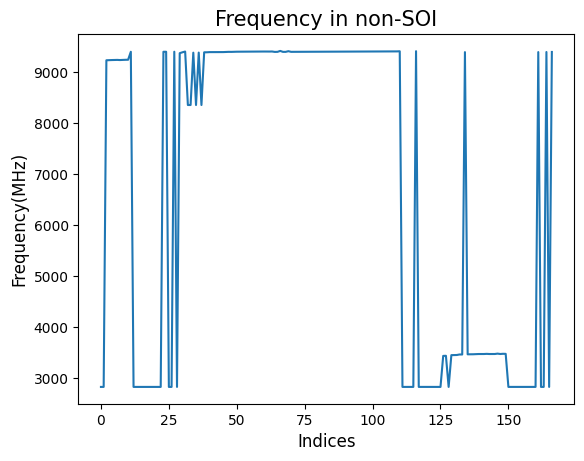

In [159]:
Graph = list(setter_freq)
pris = list(setter_pri)
#Graph.sort()
pris.sort()
xs = [z for z in range(0, len(Graph))]
plt.plot(xs, Graph)
plt.xlabel('Indices', fontsize=12)
plt.ylabel('Frequency(MHz)', fontsize=12)
plt.title('Frequency in non-SOI', fontsize=15)
plt.show()